0517结果

Single Scale: based on lev 3.

Multi Scale: sample and centered on lev 3, expand to lev 4.

先确定single 能跑，multi能跑。再multi同时产生大量lev3&lev4的图，跑multi，再跑single.

最后比较两者在lev3的heatmap.

最后的最后，roc, froc之类

# 1. Single Scale, Train Step

## 1.1. Random sample center point

## 1.2. Generate patches

In [0]:
# Expand a 299*299 patch around the center tissue
ipatch = read_slide(slide, 
                   x=int(center[0]-149)*down_factor[ilevel], #16 for lev4, 8 for lev3 
                   y=int(center[1]-149)*down_factor[ilevel], 
                   level=ilevel, 
                   width=299, 
                   height=299)

# Check whether the 128*128 center pixels(lev3) have tumor
ipixels = read_slide(tumor_mask,
                     x = int(center[0]-63)*down_factor[ilevel], 
                     y = int(center[1]-63)*down_factor[ilevel],
                     level = ilevel,
                     width = 128,
                     height = 128)[:,:,0]

# 2. Single scale, testing step

In [0]:
#stride on the center pixcel, center[0] = 0.1w+128i, center[1] 0.1h+128j
test_center = []
test_patches = []
stride = 128
bound = 149 # (299-1)//2
width = slide.level_dimensions[ilevel][0]
height = slide.level_dimensions[ilevel][1]
nx = (int(width*0.9)-int(width*0.1))//stride + 1
ny = (int(height*0.9)-int(height*0.1))//stride + 1
for i in range(nx):
  for j in range(ny):
    patch_ij = read_slide(slide,
                          x = int(0.1*width+stride*i-bound)*down_factor[ilevel],
                          y = int(0.1*height+stride*j-bound)*down_factor[ilevel],
                          level = ilevel,
                          width = input_size,
                          height = input_size)
    test_patches.append(patch_ij)
    test_center.append((int(0.1*width+stride*i-63), int(0.1*height+stride*j-63)))
    


after testing, return predicted prob with coordinate from test_center

# 3. Multi-scale, Training


## 3.1. Random sample center point on lev 3

## 3.2. Generate patches on both lev3&lev4

In [0]:
# Expand a 299*299 patch around the center tissue
ipatch3 = read_slide(slide, 
                   x=int(center[0]-149)*down_factor[ilevel], #16 for lev4, 8 for lev3 
                   y=int(center[1]-149)*down_factor[ilevel], 
                   level=ilevel, 
                   width=299, 
                   height=299)

# Check whether the 128*128 center pixels(lev3) have tumor
ipixels = read_slide(tumor_mask,
                     x = int(center[0]-63)*down_factor[ilevel], 
                     y = int(center[1]-63)*down_factor[ilevel],
                     level = ilevel,
                     width = 128,
                     height = 128)[:,:,0]

确定要了，再lev4

In [0]:
ipatch4 = read_slide(slide, 
                   x=int(center[0]-149)*8, #16 for lev4, 8 for lev3 
                   y=int(center[1]-149)*8, 
                   level=4, 
                   width=299, 
                   height=299)

# 4. Multi scale, Test

In [0]:
#stride on the center pixcel, center[0] = 0.1w+128i, center[1] 0.1h+128j
test_center = []
test_patches3 = []
test_patches4 = []
stride = 128
bound = 149 # (299-1)//2
width = slide.level_dimensions[ilevel][0]
height = slide.level_dimensions[ilevel][1]
nx = (int(width*0.9)-int(width*0.1))//stride + 1
ny = (int(height*0.9)-int(height*0.1))//stride + 1
for i in range(nx):
  for j in range(ny):
    ipatch_3 = read_slide(slide,
                          x = int(0.1*width+stride*i-bound)*down_factor[ilevel],
                          y = int(0.1*height+stride*j-bound)*down_factor[ilevel],
                          level = ilevel,
                          width = input_size,
                          height = input_size)
    ipatch_4 = read_slide(slide,
                          x = int(0.1*width+stride*i-bound)*down_factor[ilevel],
                          y = int(0.1*height+stride*j-bound)*down_factor[ilevel],
                          level = 4,
                          width = input_size,
                          height = input_size)
    test_patches3.append(ipatch_3)
    test_patches4.append(ipatch_4)
    test_center.append((int(0.1*width+stride*i-63), int(0.1*height+stride*j-63)))
    


只slide on lev3. lev 4是同比例放大。

# Generate lev3&4 training images together

In [0]:
def generate_train34(slide_id, nclass, tissue_intensity=0.5):
  slide_path = os.path.join(total_path,'tumor_%s.tif' %slide_id)
  tumor_mask_path = os.path.join(total_path,'tumor_%s_mask.tif' %slide_id)

  slide = open_slide(slide_path)
  print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                          slide.level_dimensions[0][0], 
                                                          slide.level_dimensions[0][1]))

  tumor_mask = open_slide(tumor_mask_path)
  print ("Read tumor mask from %s" % (tumor_mask_path))

  print("Slide includes %d levels", len(slide.level_dimensions))
  for i in range(len(slide.level_dimensions)):
      print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                               slide.level_dimensions[i], 
                                                               slide.level_downsamples[i]))
      if i < 8:
        assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
        assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

  slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=ilevel, 
                         width=slide.level_dimensions[ilevel][0], 
                         height=slide.level_dimensions[ilevel][1])
  
  # Keep only tissue regions
  tissue_pixels = list(find_tissue_pixels(slide_image, intensity=tissue_intensity))
  #print('Dimension of Tissue_pixels:', np.shape(tissue_pixels))
  percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
  print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 
  
  train_0, train_1 = [], []
  while len(train_0) < nclass or len(train_1) < nclass:
    # Random sample a tissue pixel and generate a patch centered in this pixel
    width = slide.level_dimensions[ilevel][0]
    height = slide.level_dimensions[ilevel][1]
    while True:
      center = tissue_pixels[np.random.choice(np.shape(tissue_pixels)[0])]
      if center[0] > height*0.1 and center[0] < height*0.9:
        if center[1] > width*0.1 and center[1] < width*0.9:
          break
    print(center)

    # Expand a 299*299 patch around the center tissue
    ipatch = read_slide(slide, 
                       x=int(center[0]-bound)*down_factor[ilevel], #16 for level=4 
                       y=int(center[1]-bound)*down_factor[ilevel], 
                       level=ilevel, 
                       width=input_size, 
                       height=input_size)

    # Check whether the 128*128 center pixels have tumor
    ipixels = read_slide(tumor_mask,
                         x = int(center[0]-63)*down_factor[ilevel], 
                         y = int(center[1]-63)*down_factor[ilevel],
                         level = ilevel,
                         width = tumor_check_size,
                         height = tumor_check_size)[:,:,0]
    #plt.imshow(ipixels)

    ilabel = 0
    if np.any(ipixels) == 1:
      ilabel = 1
    print('The label for the patch is:', str(ilabel))
    if ilabel == 0:
      if len(train_0) < nclass:
        train_0.append(ipatch)
        print('train_0 add one patch and current have %d patches!' %len(train_0))
    else:
      if len(train_1) < nclass:
        train_1.append(ipatch)
        print('train_1 add one patch and current have %d patches!' %len(train_1))
        
  return train_0, train_1

# For single scale, generate 0 and 1 separately

In [0]:
def generate_train_2(slide_id, ilevel=3, nclass, tissue_intensity=0.5):
  slide_path = os.path.join(total_path,'tumor_%s.tif' %slide_id)
  tumor_mask_path = os.path.join(total_path,'tumor_%s_mask.tif' %slide_id)

  slide = open_slide(slide_path)
  print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                          slide.level_dimensions[0][0], 
                                                          slide.level_dimensions[0][1]))

  tumor_mask = open_slide(tumor_mask_path)
  print ("Read tumor mask from %s" % (tumor_mask_path))

  print("Slide includes %d levels", len(slide.level_dimensions))
  for i in range(len(slide.level_dimensions)):
      print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                               slide.level_dimensions[i], 
                                                               slide.level_downsamples[i]))
      if i < 8:
        assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
        assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

  slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=ilevel, 
                         width=slide.level_dimensions[ilevel][0], 
                         height=slide.level_dimensions[ilevel][1])
  
  # Keep only tissue regions
  tissue_pixels = list(find_tissue_pixels(slide_image, intensity=tissue_intensity))
  #print('Dimension of Tissue_pixels:', np.shape(tissue_pixels))
  percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
  print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 
  
  train_0, train_1 = [], []
  while len(train_0) < nclass or len(train_1) < nclass:
    # Random sample a tissue pixel and generate a patch centered in this pixel
    width = slide.level_dimensions[ilevel][0]
    height = slide.level_dimensions[ilevel][1]
    while True:
      center = tissue_pixels[np.random.choice(np.shape(tissue_pixels)[0])]
      if center[0] > height*0.1 and center[0] < height*0.9:
        if center[1] > width*0.1 and center[1] < width*0.9:
          break
    print(center)

    # Expand a 299*299 patch around the center tissue
    ipatch = read_slide(slide, 
                       x=int(center[0]-bound)*down_factor[ilevel], #16 for level=4 
                       y=int(center[1]-bound)*down_factor[ilevel], 
                       level=ilevel, 
                       width=input_size, 
                       height=input_size)

    # Check whether the 128*128 center pixels have tumor
    ipixels = read_slide(tumor_mask,
                         x = int(center[0]-63)*down_factor[ilevel], 
                         y = int(center[1]-63)*down_factor[ilevel],
                         level = ilevel,
                         width = tumor_check_size,
                         height = tumor_check_size)[:,:,0]
    #plt.imshow(ipixels)

    ilabel = 0
    if np.any(ipixels) == 1:
      ilabel = 1
    print('The label for the patch is:', str(ilabel))
    if ilabel == 0:
      if len(train_0) < nclass:
        train_0.append(ipatch)
        print('train_0 add one patch and current have %d patches!' %len(train_0))
    else:
      if len(train_1) < nclass:
        train_1.append(ipatch)
        print('train_1 add one patch and current have %d patches!' %len(train_1))
        
  return train_0, train_1

# test batch training and one test

In [2]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (178 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 130824 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
ilevel = 3
input_size = 299
train_dir = 'drive/My Drive/project-adl/train_level%d'%ilevel
nclass = 80

In [7]:
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [11]:
EPOCHS = 50
BATCH_SIZE = 32
TARGET_SHAPE = input_size

conv_base = InceptionV3(weights='imagenet',include_top=False, input_shape=(299,299,3))
#conv_base_2.summary()
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 2048)) # get from conv_base.summary()
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)       
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, nclass*2)
#print(train_labels)

FLATTENED_SHAPE = 8 * 8 * 2048
train_features = np.reshape(train_features, (nclass*2, FLATTENED_SHAPE))
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE)#,validation_split = 0.2)

Found 160 images belonging to 2 classes.
Epoch 1/50
160/160 [==============================] - 3s 21ms/sample - loss: 2.6249 - acc: 0.7375
Epoch 2/50
160/160 [==============================] - 3s 16ms/sample - loss: 1.9511 - acc: 0.8625
Epoch 3/50
160/160 [==============================] - 3s 16ms/sample - loss: 1.2944 - acc: 0.9125
Epoch 4/50
160/160 [==============================] - 3s 16ms/sample - loss: 0.8687 - acc: 0.9375
Epoch 5/50
160/160 [==============================] - 3s 16ms/sample - loss: 1.1596 - acc: 0.9250
Epoch 6/50
160/160 [==============================] - 3s 16ms/sample - loss: 0.6006 - acc: 0.9500
Epoch 7/50
160/160 [==============================] - 3s 16ms/sample - loss: 0.6997 - acc: 0.9563
Epoch 8/50
160/160 [==============================] - 3s 16ms/sample - loss: 0.4788 - acc: 0.9688
Epoch 9/50
160/160 [==============================] - 3s 16ms/sample - loss: 0.6616 - acc: 0.9563
Epoch 10/50
160/160 [==============================] - 3s 16ms/sample - loss:

## test with one

In [0]:
ilevel = 3
slide_id = '110'

In [0]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    #print('1')
    im = slide.read_region((x,y), level, (width, height))
    #print('2')
    im = im.convert('RGB') # drop the alpha channel
    #print('3')
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [15]:
total_path = '/content/drive/My Drive/project-adl'
slide_path = os.path.join(total_path,'slides/tumor_%s.tif' %slide_id)
tumor_mask_path = os.path.join(total_path,'slides/tumor_%s_mask.tif' %slide_id)

slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    if i < 8:
      assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
      assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from /content/drive/My Drive/project-adl/slides/tumor_110.tif with width: 94208, height: 71680
Read tumor mask from /content/drive/My Drive/project-adl/slides/tumor_110_mask.tif
Slide includes %d levels 9
Level 0, dimensions: (94208, 71680) downsample factor 1
Level 1, dimensions: (47104, 35840) downsample factor 2
Level 2, dimensions: (23552, 17920) downsample factor 4
Level 3, dimensions: (11776, 8960) downsample factor 8
Level 4, dimensions: (5888, 4480) downsample factor 16
Level 5, dimensions: (2944, 2240) downsample factor 32
Level 6, dimensions: (1472, 1120) downsample factor 64
Level 7, dimensions: (736, 560) downsample factor 128
Level 8, dimensions: (368, 280) downsample factor 256


In [0]:
patch_ij = read_slide(slide,
                      x = 30000,
                      y = 30000,
                      level = ilevel,
                      width = input_size,
                      height = input_size)

In [19]:
patch_ij = (patch_ij/255.).reshape(-1,299,299,3)
features_ij = conv_base.predict(patch_ij)
features_ij = np.reshape(features_ij,(1, FLATTENED_SHAPE))
model.predict(features_ij)[:]

array([[1.]], dtype=float32)

In [21]:
input_size = 299
tumor_check_size = 128
bound = (input_size - 1)/2

down_factor = dict()
for i in range(8):
  down_factor[i] = 2**i
print(down_factor)

{0: 1, 1: 2, 2: 4, 3: 8, 4: 16, 5: 32, 6: 64, 7: 128}


In [30]:
stride = 128
bound = 149 # (299-1)//2
width = slide.level_dimensions[ilevel][0]
height = slide.level_dimensions[ilevel][1]
nx = (int(width*0.9)-int(width*0.1))//stride + 1
ny = (int(height*0.9)-int(height*0.1))//stride + 1
pred = np.zeros((ny, nx))
test_label = np.zeros((ny, nx))
for i in range(nx):
  for j in range(ny):
    print(i,j)
    patch_ij = read_slide(slide,
                          x = int(0.1*width+stride*i-bound)*down_factor[ilevel],
                          y = int(0.1*height+stride*j-bound)*down_factor[ilevel],
                          level = ilevel,
                          width = input_size,
                          height = input_size)
    patch_ij = (patch_ij/255.).reshape(-1,299,299,3)
    features_ij = conv_base.predict(patch_ij)
    features_ij = np.reshape(features_ij,(1, FLATTENED_SHAPE))
    pred[j][i] = model.predict(features_ij)[:]
    #print(i,j, model.predict(features_ij)[:], model.predict_proba(features_ij)[:])

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47
2 48
2 49
2 50
2 51
2 52
2 53
2 54
2 55
2 56
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
3 33
3 34
3 35
3 36


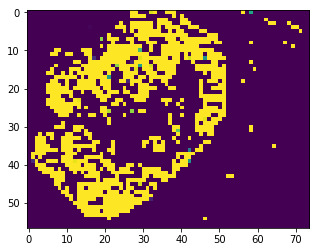

In [31]:
import matplotlib.pyplot as plt
plt.imshow(pred)

model.predict_proba(features_ij)